### Sundqvist Scheme

How about we fit the Sundqvist model where we fit the tuning parameters to the data? <br>
We let the parameters depend on whether they are taken over land or over the sea.

In [1]:
# 1000 samples, grid_spacing of 0.2: 12 seconds
# 1000 samples, grid_spacing of 0.1: 130 seconds

# 100.000 samples, grid_spacing of 0.2: 850 seconds
# 100.000 samples, grid_spacing of 0.1: Should take 2-3 hours

In [12]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '/home/b/b309170/workspace_icon-ml/symbolic_regression/')
from functions import evaluate_sundqvist

# Grid search space of hyperparameters
grid_spacing = 0.024

# Shall we use the tuned hyperparameters?
tuned = False

# Added to the PDF name
ran = np.random.randint(10**3)
print(ran)

341


In [3]:
# Load columns of data
folder_data = '/home/b/b309170/my_work/icon-ml_data/cloud_cover_parameterization/grid_cell_based_v3/based_on_var_interpolated_data'

input_train = np.load(os.path.join(folder_data, 'cloud_cover_all_days_input_train_1.npy'))
input_valid = np.load(os.path.join(folder_data, 'cloud_cover_all_days_input_valid_1.npy'))
output_train = np.load(os.path.join(folder_data, 'cloud_cover_all_days_output_train_1.npy'))
output_valid = np.load(os.path.join(folder_data, 'cloud_cover_all_days_output_valid_1.npy'))

In [4]:
# Unscale the data
mean = [5.37518440e-03, 4.65389731e-07, 2.59635412e+02, 5.52329389e+04, 6.79260772e+03, 2.58097095e-01]
std = [6.01943993e-03, 3.95009930e-06, 3.55940285e+01, 3.26642242e+04, 6.20726361e+03, 4.28313535e-01]

input_train = input_train*std + mean
input_valid = input_valid*std + mean

In [5]:
# Load surface pressure
ps_train = np.load(os.path.join(folder_data, 'ps_unscaled_input_train_1.npy'))
ps_valid = np.load(os.path.join(folder_data, 'ps_unscaled_input_valid_1.npy'))

In [6]:
input_train = np.concatenate((input_train, np.expand_dims(ps_train, 1)), axis=1)
input_valid = np.concatenate((input_valid, np.expand_dims(ps_valid, 1)), axis=1)

In [7]:
# Features
new_features = ['qv', 'qi', 'temp', 'pres', 'zg', 'fr_land', 'ps']

# To locate variables
loc = {}
for i in range(len(new_features)):
    loc[new_features[i]] = i
    
input_train.shape

(26482169, 7)

In [8]:
# Add relative humidity
pres_train = input_train[:, loc['pres']]
qv = input_train[:, loc['qv']]
temp = input_train[:, loc['temp']]

T0 = 273.15
r = 0.00263*pres_train*qv*np.exp((17.67*(temp-T0))/(temp-29.65))**(-1)

new_features.append('rh')
input_train = np.append(input_train, np.expand_dims(r, -1), axis=1)

# The same for input_valid
pres_valid = input_valid[:, loc['pres']]
qv = input_valid[:, loc['qv']]
temp = input_valid[:, loc['temp']]

T0 = 273.15
r = 0.00263*pres_valid*qv*np.exp((17.67*(temp-T0))/(temp-29.65))**(-1)

input_valid = np.append(input_valid, np.expand_dims(r, -1), axis=1)

In [9]:
# Updating loc
loc = {}
for i in range(len(new_features)):
    loc[new_features[i]] = i
    
input_train.shape

(26482169, 8)

In [10]:
# We split the training data into cells over land vs sea
land_ind = np.where(input_train[:, loc['fr_land']] > 0.5)[0]
sea_ind = np.where(input_train[:, loc['fr_land']] <= 0.5)[0]

input_land = input_train[land_ind]
output_land = output_train[land_ind]
input_sea = input_train[sea_ind]
output_sea = output_train[sea_ind]

In [11]:
len(land_ind)/input_train.shape[0]

0.260109660957152

### Fitting hyperparameters
Originally: $r_{sat} = 1, r_{0, top} = 0.8, r_{0, surf} = 0.968, n = 2$

Final over land:
$r_{sat} = 1.12, r_{0, top} = 0.3, r_{0, surf} = 0.92, n = 0.8$

Final over sea:
$r_{sat} = 1.07, r_{0, top} = 0.42, r_{0, surf} = 0.9, n = 1.1$

In [46]:
# rsat actually shouldn't really ever be smaller than r0_top or r0_surf

# # First try:
# rsat_range = np.arange(0.9, 1.1, grid_spacing)
# r0_top_range = np.arange(0.6, 1, grid_spacing)
# r0_surf_range = np.arange(0.6, 1, grid_spacing)
# n_range = np.arange(1, 3, grid_spacing)

# # Second try (0.025):
# rsat_range_land = np.arange(1.05, 1.15, grid_spacing)
# r0_top_range_land = np.arange(0.5, 0.65, grid_spacing)
# r0_surf_range_land = np.arange(0.75, 0.85, grid_spacing)
# n_range_land = np.arange(1, 2, grid_spacing)

# rsat_range_sea = np.arange(1.05, 1.15, grid_spacing)
# r0_top_range_sea = np.arange(0.75, 0.9, grid_spacing)
# r0_surf_range_sea = np.arange(0.75, 0.9, grid_spacing)
# n_range_sea = np.arange(1.5, 2.5, grid_spacing)

# # Third try (0.024):
# rsat_range_land = np.arange(1.12, 1.22, grid_spacing)
# r0_top_range_land = np.arange(0.4, 0.5, grid_spacing)
# r0_surf_range_land = np.arange(0.85, 0.95, grid_spacing)
# n_range_land = np.arange(1.05, 1.15, grid_spacing)

# rsat_range_sea = np.arange(1, 1.1, grid_spacing)
# r0_top_range_sea = np.arange(0.55, 0.65, grid_spacing)
# r0_surf_range_sea = np.arange(0.85, 0.95, grid_spacing)
# n_range_sea = np.arange(1.05, 1.15, grid_spacing)

# # Forth try
# rsat_range_land = np.array([1.12])
# r0_top_range_land = np.arange(0.3, 0.4, grid_spacing)
# r0_surf_range_land = np.array([0.92])
# n_range_land = np.arange(0.95, 1.05, grid_spacing)

# rsat_range_sea = np.array([1.07])
# r0_top_range_sea = np.arange(0.45, 0.55, grid_spacing)
# r0_surf_range_sea = np.array([0.9])
# n_range_sea = np.array([1.1])

# Forth round
rsat_range_land = np.array([1.12])
r0_top_range_land = np.array([0.3])
r0_surf_range_land = np.array([0.92])
n_range_land = np.arange(0.75, 0.85, grid_spacing) # 0.8

rsat_range_sea = np.array([1.07])
r0_top_range_sea = np.arange(0.35, 0.45, grid_spacing) # 0.42
r0_surf_range_sea = np.array([0.9])
n_range_sea = np.array([1.1])

**Land**

In [47]:
t0 = time.time()

In [48]:
no_samples_land = input_land.shape[0]
mse_tensor_land = -np.ones((len(rsat_range_land), len(r0_top_range_land), len(r0_surf_range_land), len(n_range_land)))

# Inefficient grid search of best parameters
i1 = -1
for rsat in rsat_range_land:
    i2 = -1
    i1 += 1
    for r0_top in r0_top_range_land:
        i3 = -1
        i2 += 1
        for r0_surf in r0_surf_range_land:
            i4 = -1
            i3 += 1
            for n in n_range_land:
                i4 += 1
                # What is the average error with this set of tuning parameters?
                ps = input_land[:, loc['ps']]
                p = input_land[:, loc['pres']]
                r = input_land[:, loc['rh']]
                r0 = r0_top + (r0_surf - r0_top)*np.exp(1-(ps/p)**n)
                c = np.where(r>r0, 1-np.sqrt((np.minimum(r, rsat) - rsat)/(r0 - rsat)), 0)
                
                mse_tensor_land[i1, i2, i3, i4] = np.mean((100*c - output_land)**2)
                
# assert np.all(mse_tensor_land >= 0)
np.save('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_tuning_narval_r2b4/mse_tensor_land_%d.npy'%ran, mse_tensor_land)

In [49]:
print('Time it took to get through land: %.3f'%(time.time() - t0))

Time it took to get through land: 3.668


**Sea**

In [39]:
t0 = time.time()

In [40]:
no_samples_sea = input_sea.shape[0]
mse_tensor_sea = -np.ones((len(rsat_range_sea), len(r0_top_range_sea), len(r0_surf_range_sea), len(n_range_sea)))

# Inefficient grid search of best parameters
i1 = -1
for rsat in rsat_range_sea:
    i2 = -1
    i1 += 1
    for r0_top in r0_top_range_sea:
        i3 = -1
        i2 += 1
        for r0_surf in r0_surf_range_sea:
            i4 = -1
            i3 += 1
            for n in n_range_sea:
                i4 += 1
                # What is the average error with this set of tuning parameters?
                ps = input_sea[:, loc['ps']]
                p = input_sea[:, loc['pres']]
                r = input_sea[:, loc['rh']]
                r0 = r0_top + (r0_surf - r0_top)*np.exp(1-(ps/p)**n)
                c = np.where(r>r0, 1-np.sqrt((np.minimum(r, rsat) - rsat)/(r0 - rsat)), 0)
                
                mse_tensor_sea[i1, i2, i3, i4] = np.mean((100*c - output_sea)**2)

# assert np.all(mse_tensor_sea >= 0)
np.save('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_tuning_narval_r2b4/mse_tensor_sea_%d.npy'%ran, mse_tensor_sea)

In [41]:
print('Time it took to get through the sea: %.3f'%(time.time() - t0))

Time it took to get through the sea: 9.092


### Plotting the results (To run)

In [50]:
mse_tensor_land = np.load('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_tuning_narval_r2b4/mse_tensor_land_%d.npy'%ran)

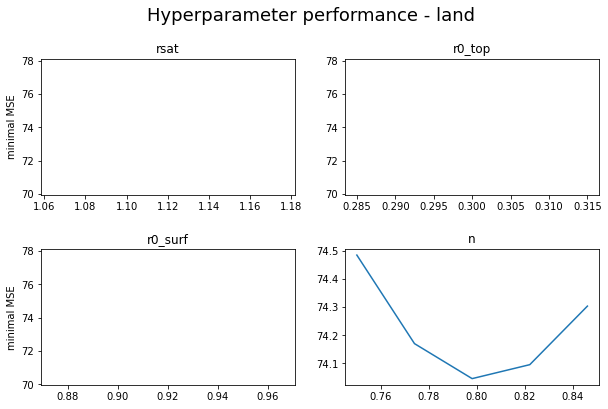

In [51]:
plt.figure(figsize=(10, 6))
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Hyperparameter performance - land", fontsize=18, y=1)

hyp_par = ['rsat', 'r0_top', 'r0_surf', 'n']
hyp_par_range = [rsat_range_land, r0_top_range_land, r0_surf_range_land, n_range_land]

axes = (0,1,2,3)
for i, par in enumerate(hyp_par):
    # Add new subplot iteratively
    ax = plt.subplot(2, 2, i + 1)
    
    axis = axes[:i] + axes[(i+1):]
    ax.plot(hyp_par_range[i], np.min(mse_tensor_land, axis=axis))
    
    ax.set_title(par)
    if i in [0, 2]:
        ax.set_ylabel('minimal MSE')

plt.savefig('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_tuning_narval_r2b4/hyp_land_%d.pdf'%ran, \
            bbox_inches='tight')

In [44]:
mse_tensor_sea = np.load('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_tuning_narval_r2b4/mse_tensor_sea_%d.npy'%ran)

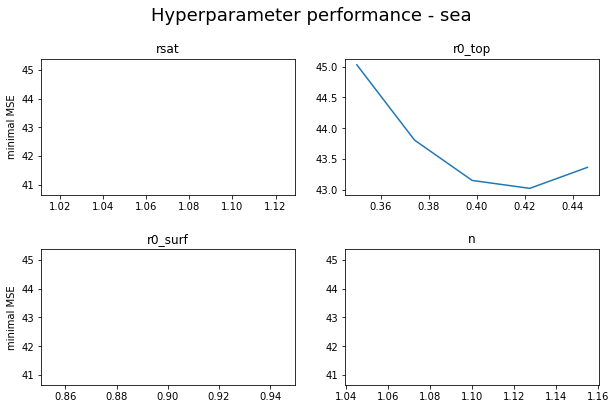

In [45]:
plt.figure(figsize=(10, 6))
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Hyperparameter performance - sea", fontsize=18, y=1)

hyp_par = ['rsat', 'r0_top', 'r0_surf', 'n']
hyp_par_range = [rsat_range_sea, r0_top_range_sea, r0_surf_range_sea, n_range_sea]

axes = (0,1,2,3)
for i, par in enumerate(hyp_par):
    # Add new subplot iteratively
    ax = plt.subplot(2, 2, i + 1)
    
    axis = axes[:i] + axes[(i+1):]
    ax.plot(hyp_par_range[i], np.min(mse_tensor_sea, axis=axis))
    
    ax.set_title(par)
    if i in [0, 2]:
        ax.set_ylabel('minimal MSE')

plt.savefig('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_tuning_narval_r2b4/hyp_sea_%d.pdf'%ran, \
           bbox_inches='tight')

### Performance with the best hyperparameter setting (To run)

In [15]:
tuned='manually'

In [16]:
mse_train, r2_train = evaluate_sundqvist(input_train, output_train, loc, tuned)
mse_train_land, r2_train_land = evaluate_sundqvist(input_land, output_land, loc, tuned)
mse_train_sea, r2_train_sea = evaluate_sundqvist(input_sea, output_sea, loc, tuned)
mse_valid, r2_valid = evaluate_sundqvist(input_valid, output_valid, loc, tuned)

In [17]:
with open('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_results/manual_gradient_descent/results.txt', 'a') as file:
    file.write('With tuned hyperparameters: %s\n'%tuned)
    file.write('Training score:\n')
    file.write('MSE: %.3f, R2: %.3f\n'%(mse_train, r2_train))
    file.write('Over land: \n')
    file.write('MSE: %.3f, R2: %.3f\n'%(mse_train_land, r2_train_land))
    file.write('Over sea:\n')
    file.write('MSE: %.3f, R2: %.3f\n'%(mse_train_sea, r2_train_sea))
    file.write('Validation score:\n')
    file.write('MSE: %.3f, R2: %.3f\n\n'%(mse_valid, r2_valid))